In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Importing the necessary packages

In [2]:
import os
import numpy as np
import glob
from IPython.utils import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, RepeatVector, Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from numpy import save, load
from pickleshare import PickleShareDB
import matplotlib.pyplot as plt
import gc

Importing the picklesharedb that was created in part 0. Displaying the keys that can be found in the db which contain the X train, val and test as well as ytest and ytrain.

In [3]:
db=PickleShareDB(r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning/assign4.pshare') 

Assiging the respective datasets needed to train, validate and test the autoencoder below.

In [6]:
XTrain=db['XTrain']
XVal=db['XVal']
XTest=db['XTest']
yTrain=db['yTrain']
yVal=db['yVal']
yTest=db['yTest']

Defining hyperparameters to ensure the maxlen of each embedding is 80, the max words is 10,000, batch size 32 and embedding dimensions equal to 100.

In [7]:
maxLen=80
maxWords=10000
batch_size=32
emDim=100

In [8]:
from tensorflow.keras.backend import clear_session
clear_session()

In [9]:
gc.collect()

50

Below the encoder portion of the autoencoder is created. Below in comments each section of code is described.

In [10]:
#Input shape is definded below and assigned to inputPadded variable. 
#Utilizing the maxLen hyperparameter set above, the input shape is set to 80,0 
inputPadded=Input(shape=(maxLen,))
#embedding layer is defined below. the embedding layer takes 3 inputs, input_dim = maxWords, output_dim = emDim, and input_length = maxLen 
embedLayer=Embedding(maxWords,output_dim=emDim,input_length=maxLen)
#Embedding the inputdata and assigning it to x
x = embedLayer(inputPadded)
#defining the output as bidirectional, this propagates the inputs in the forward and reverse direction
#and then combines the outputs. Long short term memory is used to understand context of words. Activation ReLu is used.
state_hidden=Bidirectional(LSTM(32,activation='relu'))(x)
# the input and output is fed into the the model which is defined below.
encodeM=Model(inputs=inputPadded,outputs=state_hidden)
#Output of the encoder is defined below
decoderOut=encodeM(inputPadded)

The decoder portion of the autoencoder is created below. Details of what each portion of code is doing is in the comments.

In [11]:
#creating the decoded variable utilizing repeat vector layers api to repeat the vector maxLen times for each encoder output
decoded=RepeatVector(maxLen)(decoderOut)
#decode bidirectional long short-term memory is defined below with return sequence set to true, which enables the bidirectional capability
dec_lstm=Bidirectional(LSTM(32,return_sequences=True))
#decode is then utilized with the decoded variable
decoded_lstm_output=dec_lstm(decoded)
#Creating a dense NN layer below with units = maxwords and activation of softmax as it is the output
dec_dense=Dense(maxWords,activation='softmax')
#using the decodeed_lstm_output as the input for the dense layer to get the output of the decode section
decoder_outputs=dec_dense(decoded_lstm_output)

Below is the completed autoencoder feed by the inputlayer out the encoder and output layer of the decoder

In [12]:
autoEnc_Model=Model(inputPadded,decoder_outputs)

One quick thing that you notice from summary that is different from the code used to create the autoencoder is that that shape is 80,64 for some of the layer even when 32 was defined in the autoencoder. It is 64 due to the fact that bidirectional was used for the amount is doubled. This is why you see 64 in summary but 32 in the autoencoder code.

In [13]:
autoEnc_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
model (Functional)           (None, 64)                1034048   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 80, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 64)            24832     
_________________________________________________________________
dense (Dense)                (None, 80, 10000)         650000    
Total params: 1,708,880
Trainable params: 1,708,880
Non-trainable params: 0
_________________________________________________________________


Compiling the autoEnc_model with the Nadam optimizer with a learning rate of 0.0001. The loss function is set to sparse_categorical_crossentropy to save time in memory by only using a single integer for a class rather than a whole vector

In [14]:
autoEnc_Model.compile(optimizer=Nadam(lr=0.0001),
                      loss='sparse_categorical_crossentropy'
                     )

Utilizing early stopping with a patience of 3 and monitoring the val_loss. This means the model will stop either after 30 epochs have been completed or after 3 consecutive epochs where there is no improvement in val_loss

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',patience=3)

In [16]:
history=autoEnc_Model.fit(XTrain,np.expand_dims(XTrain,-1),
                         batch_size=batch_size,
                         epochs=30,
                         validation_data=(XVal,XVal),
                         verbose=0,
                         callbacks=[callback])

In [17]:
from plot_keras_history import plot_history 

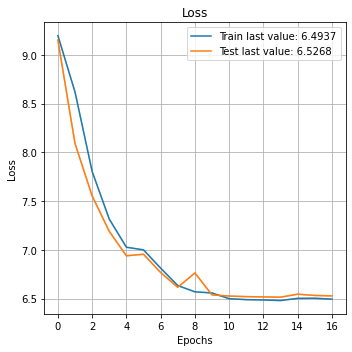

In [18]:
plot_history(history.history)

Utilizing the new autoencoder generating new embeddings for xtrain, xval and xtest below

In [19]:
XTrainEm=encodeM.predict(XTrain)
XTrainEm.shape
yTrainEm=encodeM.predict(yTrain)
yTrainEm.shape

(2000, 64)

In [20]:
XValEm=encodeM.predict(XVal)
XValEm.shape
yValEm=encodeM.predict(yVal)
yValEm.shape

(6000, 64)

In [21]:
XTestEm=encodeM.predict(XTest)
XTestEm.shape
yTestEm=encodeM.predict(yTest)
yTestEm.shape

(6000, 64)

As can be seen above, the Autoencoder reduced the len of the embeddings from 80 to 64. Saving the new XTrain, XVal and XTest embeddings generated by the autoencoder below.

In [23]:
db4 = PickleShareDB(r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\assign4.pshare')
db4['XTrainEm']=XTrainEm
db4['XValEm']=XValEm
db4['XTestEm']=XTestEm
db4['yTrainEm']=yTrain
db4['yValEm']=yVal
db4['yTestEm']=yTest